## Airbnb project

In [217]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import seaborn as sns
import numpy as np
import shapely
from geopy import distance

In [218]:
pd.options.mode.chained_assignment = None

In [219]:
metro = gpd.read_file('metro.geojson')
df = pd.read_csv('listings.csv')

# Metro dataset

In [220]:
df2 = metro.copy()
for i in range(len(df2)):
    if not '/' in df2['LINHA'][i]:
        df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [221]:
for i in range(len(metro)):
    if '/' in  metro['LINHA'][i]:
        metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]

for j in range(len(df2)):
    df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]
    
metro = pd.concat([metro, df2])

In [222]:
metro = pd.concat([metro, df2])
metro = metro.drop(columns = ['index','OBJECTID','COD_SIG','IDTIPO','SITUACAO','GlobalID'])

In [223]:
metro

,NOME,LINHA,geometry
0,Cais do Sodré,Verde,POINT (-9.14609 38.70627)
1,Terreiro do Paço,Azul,POINT (-9.13419 38.70728)
2,Baixa Chiado,Azul,POINT (-9.14015 38.71057)
3,Santa Apolónia,Azul,POINT (-9.12241 38.71404)
4,Rossio,Verde,POINT (-9.13792 38.71418)
...,...,...,...
1,Marquês de Pombal,Amarela,POINT (-9.15005 38.72532)
2,São Sebastião,Vermelha,POINT (-9.15394 38.73453)
3,Saldanha,Vermelha,POINT (-9.14533 38.73532)
4,Alameda,Vermelha,POINT (-9.13387 38.73697)


In [224]:
yellow = metro[metro.LINHA == 'Amarela'].reset_index()
blue = metro[metro.LINHA == 'Azul'].reset_index()
green = metro[metro.LINHA == 'Verde'].reset_index()
red = metro[metro.LINHA == 'Vermelha'].reset_index()

# Metro Network

In [225]:
import networkx as nx
from pyvis.network import Network

Import the graph baseline from excel where we have column for Origin and Destination

In [226]:
metro_graph = pd.read_excel('metro.xlsx')

In [227]:
metro_graph = metro_graph.dropna()
metro_graph = metro_graph.drop(columns = ['NOME', 'LINHA', 'Unnamed: 0', 'OBJECTID'])

## Set up the graph

In [228]:
G = nx.Graph()
G = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination')

In [229]:
net = Network(notebook=True)
net.from_nx(G)
net.width=500
net.height=500
net.show('metro.html')

Get the origin and destination coordinates

In [230]:
metro_dict = dict(zip(metro.NOME, metro.geometry))
metro_graph['p1'] = (metro_graph['Origin']).map(metro_dict)
metro_graph['p2'] = (metro_graph['Destination']).map(metro_dict)

Create a LineString object between origin and Destination

In [231]:
a = []
for i in range(len(metro_graph)):
    a.append((LineString([metro_graph.p1[i],metro_graph.p2[i]])))

metro_graph['LineString'] = a

Transform the graph in a Geopandas Datframe

In [232]:
metro_graph = gpd.GeoDataFrame(metro_graph)

## Calculate distance between nodes

In [233]:
from shapely.geometry import LineString
from shapely.ops import transform
from functools import partial
import pyproj

This function transforms the LineString distance in Meters

In [234]:
def transform_linestring(df):
    
    lenghts = []
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for line in df.LineString:
        lenghts.append(int(transform(project, line).length))
    
    df['distance_meters'] = lenghts

In [235]:
transform_linestring(metro_graph)

We now have a graph with a distance attribute to calculate degree importance based on.

In [236]:
G_distance = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination',['distance_meters'])

### Degrees

In [237]:
#degree_sort = sorted(G_distance.degree(), key=lambda x: x[1], reverse=True)
degrees = {node:val for (node, val) in G_distance.degree()}

closeness = nx.closeness_centrality(G_distance, distance='distance_meters')

between = nx.betweenness_centrality(G_distance, weight='distance_meters')

eigen = nx.eigenvector_centrality(G_distance,max_iter=10000, weight='distance_meters')

centrality = nx.degree_centrality(G_distance)

In [238]:
betweness = pd.DataFrame.from_dict(between, orient='index').rename(columns = {0: 'Betweness'}).reset_index().rename(columns = {'index': 'station'})
closeness = pd.DataFrame.from_dict(closeness, orient='index').rename(columns = {0: 'Closeness'}).reset_index().rename(columns = {'index': 'station'})
eigeness = pd.DataFrame.from_dict(eigen, orient='index').rename(columns = {0: 'Eigeness'}).reset_index().rename(columns = {'index': 'station'})
central = pd.DataFrame.from_dict(centrality, orient='index').rename(columns = {0: 'Centrality'}).reset_index().rename(columns = {'index': 'station'})
Degree = pd.DataFrame.from_dict(degrees, orient='index').rename(columns = {0: 'Degree'}).reset_index().rename(columns = {'index': 'station'})

weight = pd.merge(betweness, closeness, on='station')
weight = pd.merge(weight, eigeness, on='station')
weight = pd.merge(weight, central, on='station')
weight = pd.merge(weight, Degree, on='station')

# AIRBNB Dataset

In [239]:
df = pd.read_csv('listings.csv')
df = df.rename(columns = {'geometry': 'Coordinate'})
df = df.drop(columns = ['host_name', 'host_id', 'license', 'id', 'name'])

In [240]:
#df.isna().sum()

In [241]:
df = df.drop(columns = ['last_review', 'reviews_per_month'])

## One-hot encoding for room_type

In [242]:
from sklearn.preprocessing import OneHotEncoder

Consider just the lisboa district

In [243]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
#gdf = gdf.drop(columns = ['longitude', 'latitude'])
gdf = gdf.rename(columns = {'geometry': 'Coordinate'})
gdf_lisboa = gdf[gdf.neighbourhood_group == 'Lisboa']

Consider prices lower than 100 euros

In [244]:
gdf_lisboa = gdf_lisboa[gdf_lisboa['price'] < 100]

## Prices per room type

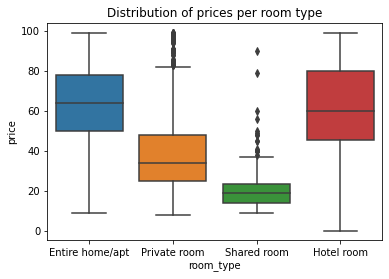

In [245]:
import seaborn as sns
#sns.displot(data = gdf_lisboa, x = 'price', kde=True).set(title = 'Price distribution');
sns.boxplot(data=gdf_lisboa, 
            y='price', 
            x='room_type').set(title='Distribution of prices per room type');

## Minimum nights distribution

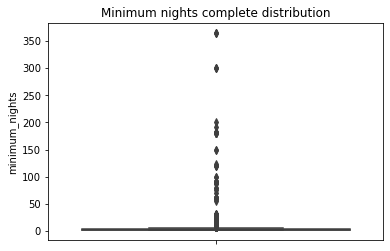

In [246]:
sns.boxplot(data = gdf_lisboa[['minimum_nights']], 
            y='minimum_nights').set(title = 'Minimum nights complete distribution');

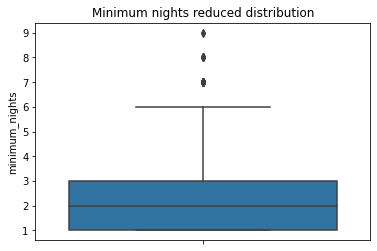

In [247]:
sns.boxplot(data = gdf_lisboa[gdf_lisboa['minimum_nights'] < 10], 
            y='minimum_nights').set(title = 'Minimum nights reduced distribution');

It's safe to consider just 10 minimum nights, since most of the observations resides between 1 and 4 minimum nights

In [248]:
gdf_lisboa = gdf_lisboa[gdf_lisboa['minimum_nights'] < 10]

## Distribution of reviews per room_type

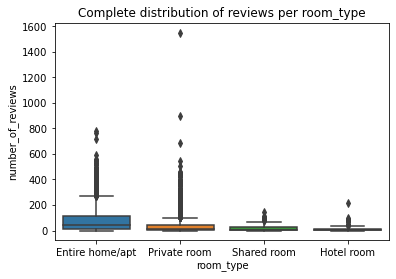

In [249]:
sns.boxplot(data = gdf_lisboa, 
            y ='number_of_reviews', 
            x='room_type',).set(title = 'Complete distribution of reviews per room_type');

We observe that the distribution of number of reviews contains many outliers for all the three kind of houses. We decide to keep the observations until 400 without deleting the ouliers based on 2 assumptions:
1) The number of outliers is consistent and relevant for the analysis.\
2) Ideally, a house with more reviews is a popular house on Airbnb, hence relevant for the analysis.

In [250]:
gdf_lisboa = gdf_lisboa[gdf_lisboa['number_of_reviews'] < 400]

In [251]:
gdf_lisboa = gdf_lisboa.reset_index()

## Assinging a specific weight to each metro station based on its:

1) Degree (#of connections)\
2) Eigenvector Centrality value\
3) Betweness value

In [252]:
weight['grade']=weight['Degree'] + weight['Eigeness']*5 + weight['Betweness']*5
# the values of the Eigenvector and Betwennes variables are multiplied by a factor of 5 in order to give them a higher relevance, 
#their importance would infact otherwise be obscured by the Degree variable which is by it own nature of a higher order of magnitude.

In [253]:
metro['station grade'] = weight['grade']

In [254]:
weight['degree_mean'] = weight.iloc[:,1:4].mean(axis=1)

In [255]:
lines_dict = dict(zip(metro.NOME, metro.LINHA))
station_coord = dict(zip(metro.NOME, metro.geometry))

weight['line_color'] = (weight['station']).map(lines_dict)
weight['Coordinate'] = (weight['station']).map(station_coord)

## Function that gives the distance in meters from a specified point to each metro station

## Deleting columns in excess

In [256]:
weight = weight.drop(columns = weight.iloc[:,9:-1].columns.tolist())
weight = weight.drop(columns = weight.iloc[:,1:4].columns.tolist())

In [257]:
weight.head()

,station,Centrality,Degree,grade,degree_mean,line_color,Coordinate
0,Reboleira,0.020408,1,1.000073,0.000030,Azul,POINT (-9.223883295575069 38.752271287954)
1,Amadora Este,0.040816,2,2.204270,0.013646,Azul,POINT (-9.217901617117381 38.758715859802)
2,Alfornelos,0.040816,2,2.399926,0.026693,Azul,POINT (-9.204477478277459 38.7605071115253)
3,Pontinha,0.040816,2,2.587180,0.039180,Azul,POINT (-9.196937374617089 38.7623917163549)
4,Carnide,0.040816,2,2.766813,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562)


# Correlation analysis between house price and distance from relevant areas of the city

Here we want to check if house prices is also affected by their location within the city. 
If we find any sort of correlation, we'll be able to strip this price component from the price itself, so that the following correlation analysis with the distance from the closest metro station will be more accurate, because it won't take into account the component of the price that varies due to a different factor.

In [258]:
#list of monuments and areas that were considered potentially relevant for the variation of hous prices
list_of_monuments_2= {'Elevador de Santa Justa': ((-9.139221, 38.712173), 1),
                    'Praça do Comércio': ((-9.136744, 38.707779), 1),
                     'Marques d Pobal' : ((-9.149809571870293, 38.72520372326393 ),1),
                     'Praca dom luois I' : (( -9.14651051085467, 38.70696585893371),1),
                     'Jardim Guerra Junqueiro (Jardim da Estrela)' : ((-9.157568180154488, 38.715165895486756),1),
                     'Miradouro de São Pedro de Alcântara' : ((-9.144383380607636, 38.714999758691214 ), 1),
                     'Assembly of the Republic' : (( -9.154170376301336, 38.71222285831986),1)
                     }

## The cell below is the one in which to insert the final reduced dataframe

In [259]:
#sorting dataset based on houses average distances from points of interest
#slicing dataset based on house type
#excluding from the analysis houses with a price higher than 150€ per night.
df = gdf_lisboa.copy()
df_red = df[df['price']<150]
df_red_apt=df_red[df_red['room_type']=='Entire home/apt']
df_red_rooms=df_red[df_red['room_type']=='Private room']
df_red_hotel=df_red[df_red['room_type']=='Hotel room']
df_red_shared=df_red[df_red['room_type']=='Shared room']

Function computing average distance between a given house and every given point of interest

In [260]:
import geopy

#computing average distance between a given house and every given point of interest

def house_avg_distance(monuments, houses,j):  
    tot_dist=0
    for i in range(len(monuments)):
        
        coord_1=(list(monuments.values())[i][0][1],list(monuments.values())[i][0][0])
        coord_2=(houses.latitude[j],houses.longitude[j])
        
        distance=geopy.distance.distance(coord_1, coord_2).km
        tot_dist=tot_dist+distance
    avg_dst=(tot_dist/len(monuments))*10
    
    return(avg_dst)   
    
    

Function computing average distance form points of interest for each house in the dataset

In [261]:
def distances(houses, monuments):
    avg_distances_list=[]   
    for i in range(len(houses)):
        avg_distances=house_avg_distance(monuments,df,i)
        avg_distances_list.append(avg_distances)
    houses['avg interest points-house distance'] = avg_distances_list

In [262]:
#computing the distance from points of interest of every single house in every subdataset
distances(df_red_apt, list_of_monuments_2)
distances(df_red_rooms, list_of_monuments_2)
distances(df_red_hotel, list_of_monuments_2)
distances(df_red_shared, list_of_monuments_2)

# In the cell below I'm reducing the number of houses considered to the ones that have an average distance from points of interest below 20km 
ale quando andrai a buttare dentro il data set giusto probabilmente questa cella non servirà


In [263]:
print(len(df_red_apt[df_red_apt['avg interest points-house distance'] < 20]))
print(len(df_red_apt))

4652
6908


In [264]:
#generates scatter plot for every sub_dataset provided to the function
def plot_gen(df):
    x = df['avg interest points-house distance']
    y = df['price']
    plt.scatter(x, y)
    plt.title(f'relation between distance from points of interest and price for {df.room_type.iloc[0]}')
    plt.xlabel('avg distance')
    plt.ylabel('price')
    plt.show()

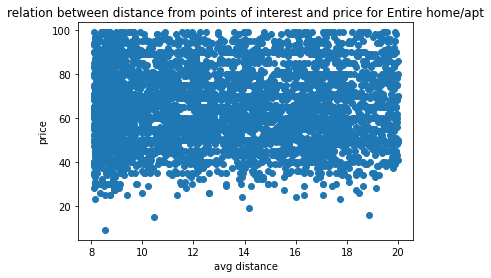

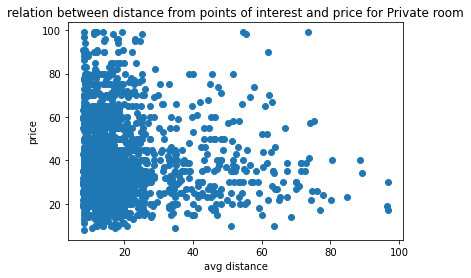

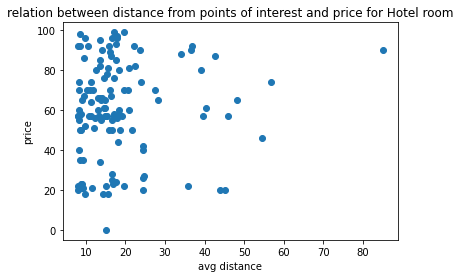

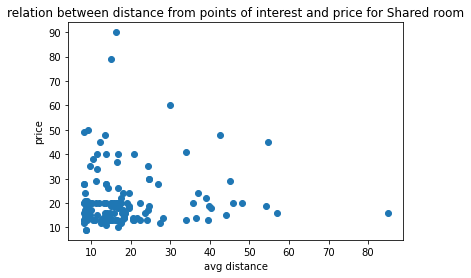

In [265]:
#scatter plots of every sub_dataset representing relation between price and average distance form points of interest
#in some of them we can already see a bit of a correlation between distance from points of interest and price.

plot_gen(df_red_apt[df_red_apt['avg interest points-house distance']<20])
for i in [df_red_rooms, df_red_hotel, df_red_shared]:
    plot_gen(i)

### Graphs above are showing pretty clearly the absence of a significant correlation between house prices and ther closeness to potentially relevant areas. this means that in the following analyis we'll be able to consider the prices as they are without the need to manipulate them, because there is no evident component (that we can compute with the available data) that is affecting the prices.

In [266]:
#showing current correlation values between average distances and prices, as the graphs above were already suggesting there is no relevant correlation 
#between the two variables
correlations={'correlation for apt' : df_red_apt['price'].corr(df_red_apt['avg interest points-house distance']),
             'correlation for rooms' : df_red_rooms['price'].corr(df_red_rooms['avg interest points-house distance']),
             'correlation for hotel' : df_red_hotel['price'].corr(df_red_hotel['avg interest points-house distance']),
             'correlation for shared rooms' : df_red_shared['price'].corr(df_red_shared['avg interest points-house distance'])}
correlations

{'correlation for apt': 0.023504714752182167,
 'correlation for rooms': -0.03345859365182565,
 'correlation for hotel': 0.1003009916014469,
 'correlation for shared rooms': 0.04699090682064793}

# Finding the closest metro station to every single house and the distance from it and attaching said information to the correspondent dataset


In [267]:
metro = metro.set_index('NOME')

In [268]:
#finds the closest metro station to a given house and computes the distance from it 
def closest_metro_station_finder(metro, houses, j):
    dist_stat=[]
    h_m_dist={}
    for i in range(len(metro)):
            point=metro.geometry[i]
            x=point.y
            y=point.x
            coord_1=(x, y)
            coord_2=(houses.latitude.iloc[j], houses.longitude.iloc[j])
            distance=geopy.distance.distance(coord_1, coord_2).km
            h_m_dist[metro.index[i]]=distance
    h_m_v=list(h_m_dist.values())
    h_m_k=list(h_m_dist.keys())
    closest_st=min(h_m_v)
    ind=h_m_v.index(closest_st)
    station=h_m_k[ind]
    dist_stat.append(closest_st)
    dist_stat.append(station)
    return dist_stat

In [269]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing shared bedrooms only
distances=[]
stations=[] 

for i in range(len(df_red_shared)):
    new_list=closest_metro_station_finder(metro, df_red_shared, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
    
df_red_shared['closest station']=stations
df_red_shared['distance from closest station']=distances

In [270]:
df_red_shared.head()

,index,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Coordinate,avg interest points-house distance,closest station,distance from closest station
62,117,Lisboa,Campolide,38.72851,-9.16644,Shared room,20,2,49,2,310,0,POINT (-9.16644 38.72851),48.089863,Praça de Espanha,1.208433
336,624,Lisboa,Areeiro,38.73862,-9.13547,Shared room,15,1,114,3,334,1,POINT (-9.13547 38.73862),18.342461,Alameda,0.230324
343,634,Lisboa,Santo Antnio,38.72372,-9.14687,Shared room,14,1,49,7,357,17,POINT (-9.14687 38.72372),18.321832,Marquês de Pombal,0.328256
996,1937,Lisboa,Misericrdia,38.71382,-9.14471,Shared room,13,1,59,10,336,0,POINT (-9.14471 38.71382),16.084885,Restauradores,0.339448
999,1940,Lisboa,Misericrdia,38.71379,-9.14319,Shared room,14,1,45,10,364,10,POINT (-9.14319 38.71379),36.540479,Restauradores,0.283691


In [271]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing entire apartments only
import time
distances=[]
stations=[] 

start = time.time()

for i in range(len(df_red_apt)):
    new_list=closest_metro_station_finder(metro, df_red_apt, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
    
df_red_apt['closest station']=stations
df_red_apt['distance from closest station']=distances


end = time.time()
print(end - start)

137.9961440563202


In [272]:
df_red_apt.head()

,index,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Coordinate,avg interest points-house distance,closest station,distance from closest station
0,0,Lisboa,Belm,38.69750,-9.19768,Entire home/apt,40,3,32,1,315,6,POINT (-9.19768 38.69750),48.089863,Rato,4.503949
1,1,Lisboa,Santa Maria Maior,38.71241,-9.12706,Entire home/apt,50,2,127,1,325,14,POINT (-9.12706 38.71241),18.342461,Santa Apolónia,0.443087
2,2,Lisboa,Santa Maria Maior,38.71082,-9.12719,Entire home/apt,60,5,337,1,190,13,POINT (-9.12719 38.71082),18.321832,Santa Apolónia,0.548231
3,3,Lisboa,Santa Maria Maior,38.71156,-9.12987,Entire home/apt,60,2,299,1,302,40,POINT (-9.12987 38.71156),16.084885,Terreiro do Paço,0.605491
4,5,Lisboa,Avenidas Novas,38.74571,-9.15264,Entire home/apt,50,5,46,1,228,8,POINT (-9.15264 38.74571),36.540479,Entre Campos,0.417752


In [273]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing private rooms only
distances=[]
stations=[] 

for i in range(len(df_red_rooms)):
    new_list=closest_metro_station_finder(metro, df_red_rooms, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
    
df_red_rooms['closest station']=stations
df_red_rooms['distance from closest station']=distances

In [274]:
df_red_rooms.head()

,index,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Coordinate,avg interest points-house distance,closest station,distance from closest station
5,6,Lisboa,Lumiar,38.76427,-9.15301,Private room,40,1,2,2,0,0,POINT (-9.15301 38.76427),48.089863,Quinta das Conchas,0.418690
16,27,Lisboa,So Domingos de Benfica,38.75643,-9.17700,Private room,62,1,0,1,0,0,POINT (-9.17700 38.75643),18.342461,Alto dos Moinhos,0.763963
19,31,Lisboa,Penha de Frana,38.72983,-9.13183,Private room,26,1,292,3,87,36,POINT (-9.13183 38.72983),18.321832,Anjos,0.393669
20,33,Lisboa,Arroios,38.71806,-9.13738,Private room,28,3,193,2,347,12,POINT (-9.13738 38.71806),16.084885,Martim Moniz,0.143587
35,59,Lisboa,Santa Maria Maior,38.71358,-9.13454,Private room,31,2,165,1,43,24,POINT (-9.13454 38.71358),36.540479,Rossio,0.301833


In [275]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing hotel rooms only
distances=[]
stations=[] 

for i in range(len(df_red_hotel)):
    new_list=closest_metro_station_finder(metro, df_red_hotel, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
                    
df_red_hotel['closest station'] = stations
df_red_hotel['distance from closest station'] = distances

In [276]:
df_red_hotel.head()

,index,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Coordinate,avg interest points-house distance,closest station,distance from closest station
947,1861,Lisboa,Santa Maria Maior,38.71066,-9.13533,Hotel room,65,1,33,5,361,2,POINT (-9.13533 38.71066),48.089863,Terreiro do Paço,0.387967
994,1932,Lisboa,Santa Maria Maior,38.71113,-9.13547,Hotel room,60,1,31,5,344,2,POINT (-9.13547 38.71113),18.342461,Rossio,0.400680
995,1933,Lisboa,Santa Maria Maior,38.70901,-9.13552,Hotel room,58,1,16,5,365,2,POINT (-9.13552 38.70901),18.321832,Terreiro do Paço,0.224139
997,1938,Lisboa,Santa Maria Maior,38.71122,-9.13618,Hotel room,70,2,2,4,105,0,POINT (-9.13618 38.71122),16.084885,Baixa Chiado,0.352811
1042,2012,Lisboa,Santa Maria Maior,38.71089,-9.13521,Hotel room,90,1,2,5,334,1,POINT (-9.13521 38.71089),36.540479,Terreiro do Paço,0.410312


In [277]:
df_apt = df_red_apt #for convenience i'm reassinging the Entire Apartment data set to a new dataframe that's easier to call
df_rooms = df_red_rooms #for convenience i'm reassinging the Private Rooms data set to a new dataframe that's easier to call
df_hotel = df_red_hotel #for convenience i'm reassinging the Hotel Rooms data set to a new dataframe that's easier to call
df_shared = df_red_shared #for convenience i'm reassinging the Shared rooms Apartment data set to a new dataframe that's easier to call

## Attaching the grades of the closest station to the Entire Apartment dataset

In [278]:
#associating grades of the closest station to the main dataset
grades=[]

for i in df_apt['closest station']:
    
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_apt['correspondent station grade'] = grades

In [279]:
df_apt.head()

,index,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Coordinate,avg interest points-house distance,closest station,distance from closest station,correspondent station grade
0,0,Lisboa,Belm,38.69750,-9.19768,Entire home/apt,40,3,32,1,315,6,POINT (-9.19768 38.69750),48.089863,Rato,4.503949,1.022765
1,1,Lisboa,Santa Maria Maior,38.71241,-9.12706,Entire home/apt,50,2,127,1,325,14,POINT (-9.12706 38.71241),18.342461,Santa Apolónia,0.443087,1.000602
2,2,Lisboa,Santa Maria Maior,38.71082,-9.12719,Entire home/apt,60,5,337,1,190,13,POINT (-9.12719 38.71082),18.321832,Santa Apolónia,0.548231,1.000602
3,3,Lisboa,Santa Maria Maior,38.71156,-9.12987,Entire home/apt,60,2,299,1,302,40,POINT (-9.12987 38.71156),16.084885,Terreiro do Paço,0.605491,2.205083
4,5,Lisboa,Avenidas Novas,38.74571,-9.15264,Entire home/apt,50,5,46,1,228,8,POINT (-9.15264 38.74571),36.540479,Entre Campos,0.417752,3.896096


## In the cell below we're creating the regressor variable, which is a combination of the inverse of the distance from the closest metro station and the weight assinged to that very station in terms of relevance within the metrostation network!
why considered the inverse of the distance from the closest metro station so that both the component of the regressor would have a "coherent" effect on the price variable. in fact the if left as they are the two components (distance and weight) would "cancel each other" because a higher distance should theoretically have a negative impact on prices while a higher grade of the closest metro station should have a positive effect. By considering the inverse of the distance if the distance from the closest metro station is higher we can assume the two components to contribute in a coherent way on the variation of the regressor

In [280]:
reverse_distance=1/df_apt['distance from closest station']
regressor=(df_apt['correspondent station grade'] + reverse_distance)
df_apt['regressor']=regressor

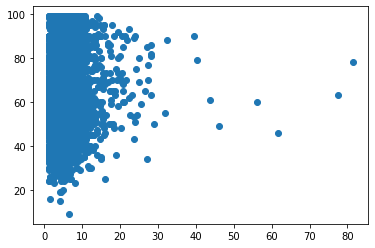

In [281]:
plt.scatter(x=df_apt['regressor'], y= df_apt['price'])

In [282]:
df_apt['price'].corr(df_apt['regressor'])

0.0824415549638895

### In the cell and graph above we can see that there are a few outlier in the regressor variable

In [283]:
#here we're removing those variables that have a regressor value over 10, in order to consider more significat data
df_apt_reducted=df_apt[df_apt['regressor']<10]
round(df_apt_reducted['price'].corr(df_apt_reducted['regressor']),2)

0.09

In [284]:
#it looks like decreasing the maximum house price considered the correlation values slowly increases
df_apt_reducted=df_apt_reducted[df_apt_reducted['price']<50]
round(df_apt_reducted['price'].corr(df_apt_reducted['regressor']),3)

0.005

### One (VERY) approximative conslusion we can draw from the fact that the correlation value seems to increase when we consider lower and lower prices could be, that the relevance of the component of price given by the presence of a metro station nearby the house decreases as the overall value of the house increase. 

In [285]:
df_apt_reducted=df_apt_reducted[df_apt_reducted['price']<30]
round(df_apt_reducted['price'].corr(df_apt_reducted['regressor']), 2)

0.02

### The value of correlation even though it remains low, does increase when we remove the outliers

In [286]:
reverse_distance=1/df_apt_reducted['distance from closest station']
regressor=(df_apt_reducted['correspondent station grade']+reverse_distance)
df_apt_reducted['regressor']=regressor

In [287]:
reg = np.polyfit(df_apt_reducted['regressor'], df_apt_reducted['price'], deg =1 )
trend = np.polyval(reg, df_apt_reducted['price'])
reg

array([ 0.03211505, 25.31179411])

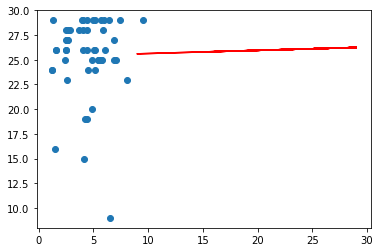

In [288]:
plt.scatter(x=df_apt_reducted['regressor'], y= df_apt_reducted['price'])
plt.plot(df_apt_reducted['price'], trend, 'r')

## attaching the grades of the closest station to the Private Rooms dataset

In [289]:
#associating grades of the closest station to the main dataset
grades=[]
for i in df_rooms['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_rooms['correspondent station grade']=grades

In [290]:
reverse_distance=1/df_rooms['distance from closest station']
regressor=(df_rooms['correspondent station grade']+reverse_distance)
df_rooms['regressor']=regressor

In [291]:
df_rooms_reduct=df_rooms[df_rooms['regressor']<10]
df_rooms_reduct['price'].corr(df_rooms_reduct['regressor'])

-0.001992562575285825

In [292]:
reg = np.polyfit(df_rooms['regressor'], df_rooms['price'], deg =1 )
trend = np.polyval(reg, df_rooms['price'])
reg

array([-0.04345805, 39.57968113])

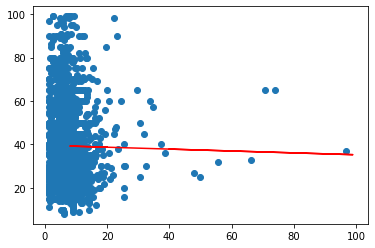

In [293]:
plt.scatter(x=df_rooms['regressor'], y= df_rooms['price'])
plt.plot(df_rooms['price'], trend, 'r')

### we can appreciate that prices for Private Rooms are concetrated in a lower range (obviously)
it makes sense to consider a reducted dataset that does not consider house above a certainv value!

In [294]:
df_rooms_1=df_rooms[df_rooms['price'] < 50]

In [295]:
grades=[]
for i in df_rooms_1['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_rooms_1['correspondent station grade']=grades

In [296]:
reverse_distance=1/df_rooms_1['distance from closest station']
regressor=(df_rooms_1['correspondent station grade']+reverse_distance)
df_rooms_1['regressor']=regressor

In [297]:
reg = np.polyfit(df_rooms_1['regressor'], df_rooms_1['price'], deg =1 )
trend = np.polyval(reg, df_rooms_1['price'])
reg

array([-2.51750297e-02,  3.09803904e+01])

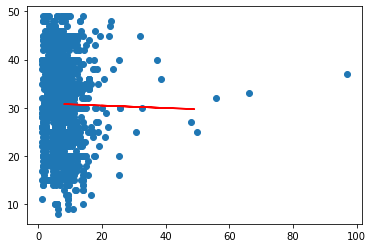

In [298]:
plt.scatter(x=df_rooms_1['regressor'], y= df_rooms_1['price'])
plt.plot(df_rooms_1['price'], trend, 'r')

### we can see that as far as Private Rooms are concerned we find no correlation of any kind between the regressor variable and the house prices.

In [299]:
grades=[]
for i in df_shared['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_shared['correspondent station grade']=grades

In [300]:
reverse_distance=1/df_shared['distance from closest station']
regressor=(df_shared['correspondent station grade']+reverse_distance)
df_shared['regressor']=regressor

In [301]:
reg = np.polyfit(df_rooms_1['regressor'], df_rooms_1['price'], deg =1 )
trend = np.polyval(reg, df_rooms_1['price'])
reg

array([-2.51750297e-02,  3.09803904e+01])

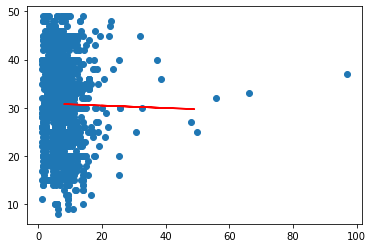

In [302]:
plt.scatter(x=df_rooms_1['regressor'], y= df_rooms_1['price'])
plt.plot(df_rooms_1['price'], trend, 'r')

### We can make similar considerations for she Shared Bedrooms, there is no sign of correlation (at least no sign of positive correlation. We can observe a very small component of negative correlation but it is actually neglecatble in terms of statistic significance.

In [303]:
len(df_red)

9266